In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_59317/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-08 08:39:03.099329: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 08:39:03.135813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 08:39:

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water,data_ice,data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

##Train test validation split##
#X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
#           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
#           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

In [20]:
data_all.reset_index()

,index,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,...,Clear_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,Surface_Desc
0,0,0.89822,0.82430,0.84322,0.75232,0.79863,0.86702,0.75245,0.91433,0.38607,...,0.38977,4.35,56.99,22.96,23.397,2,8973,0.129,6.37,water-snow-finegranular
1,1,0.29968,0.27558,0.37609,0.27122,0.48121,0.90663,0.86953,0.91666,0.40817,...,0.84026,12.27,60.32,81.41,2.452,2,3598,0.123,0.46,vegetation-shrub-ceanothus
2,2,0.37579,0.39177,0.55448,0.47159,0.79124,0.93204,0.88240,0.94466,0.37695,...,0.58545,2.12,55.76,50.24,6.564,5,9625,0.122,0.69,nonphotosyntheticvegetation-flowers-calocedrus
3,3,0.73411,0.70360,0.76401,0.74330,0.80824,0.99764,0.89247,1.03605,0.41092,...,0.84693,1.46,44.21,106.95,29.710,3,6165,0.128,2.96,vegetation-tree-podocarpus
4,4,0.61763,0.60034,0.65471,0.70713,0.73157,0.75289,0.76990,0.79839,0.66608,...,0.95261,12.33,40.58,172.91,17.975,4,2862,0.105,0.10,soil-inceptisol-xerumbrept
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,49995,0.54497,0.50832,0.61099,0.77017,0.84129,0.85560,0.81355,0.86628,0.49961,...,0.87786,7.37,70.07,40.61,11.154,10,4023,0.123,0.85,soil-inceptisol-dystrochrept
149996,49996,0.67646,0.64323,0.69696,0.67262,0.75384,1.01997,0.98172,1.02272,0.67529,...,0.68721,5.06,39.36,3.69,18.838,11,3253,0.110,0.28,vegetation-tree-pinus
149997,49997,0.80252,0.76409,0.80857,0.79187,0.83445,0.96384,0.86138,1.00325,0.50672,...,0.66330,7.75,43.19,157.29,40.314,9,5982,0.128,4.28,vegetation-tree-abies
149998,49998,0.70670,0.66006,0.70197,0.65865,0.71489,0.89682,0.76990,0.93910,0.29262,...,0.77138,6.89,59.56,156.13,26.983,10,8629,0.128,5.19,vegetation-tree-cassia


In [16]:
pd.set_option('display.max_rows',200)
print(data_all.Surface_Desc.value_counts())

Surface_Desc
vegetation-tree-quercus                            16343
vegetation-tree-pinus                               7369
vegetation-shrub-baccharis                          6976
vegetation-shrub-ceanothus                          6948
vegetation-shrub-calocedrus                         3641
vegetation-shrub-arctostaphylos                     3487
vegetation-shrub-umbellularia                       3478
vegetation-shrub-adenostoma                         3469
vegetation-tree-calocedrus                          3398
vegetation-tree-abies                               3393
vegetation-shrub-heteromeles                        3350
vegetation-shrub-salvia                             2943
vegetation-tree-bambusa                             2909
vegetation-tree-ficus                               2303
rock-igneous-felsic                                 2031
vegetation-tree-acer                                1914
vegetation-tree-eucalyptus                          1906
nonphotosyntheticv

In [4]:
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1)

In [5]:
import random

val_size=0.1
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(data_all['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 308
Model all saved...


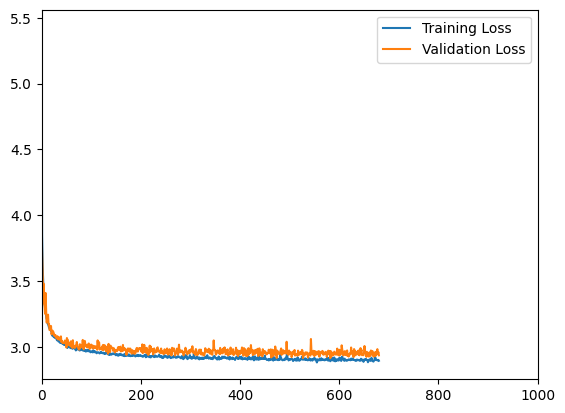

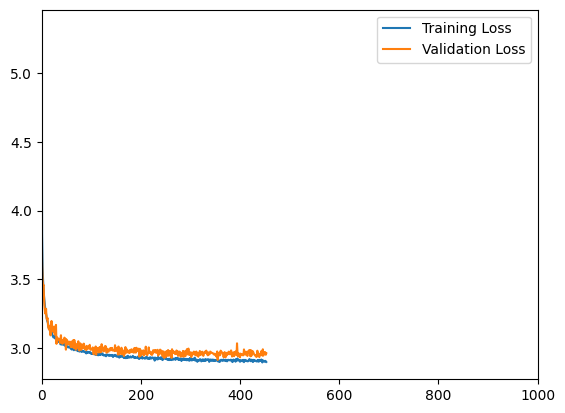

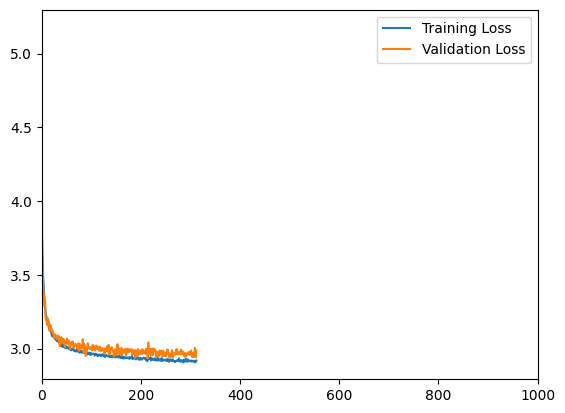

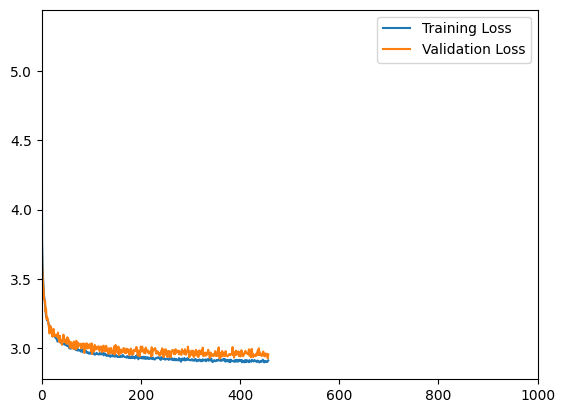

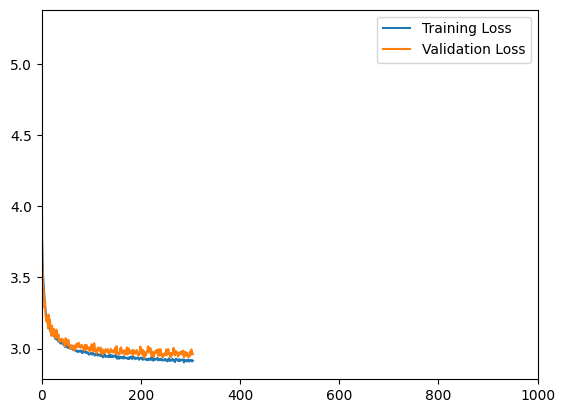

In [6]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=True
ensamble=5

nepochs=1000
models=[QuantileNetwork(quantiles=quantiles) for i in range(ensamble)]

n_nodes_all=100
sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

for i,model in enumerate(models):
    main_filepath="pytorch_models/model_7layers_100nodes_5ensemble_noclear"
    model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence_all(),
            lr=0.003,
            data_norm=True,
            verbose=False,
            plot_training=True,
            early_break=True)

    if save:
        filepath=main_filepath+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')
        print("Model all saved...")
if save:
    X_test.to_csv(main_filepath+'/xtest.csv',index=True)
    y_test.to_csv(main_filepath+'/ytest.csv',index=True)


In [18]:


#main_filepath='pytorch_models/model_7layers_100nodes_5ensemble_noclear'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
y_true=y_test.to_numpy()

In [34]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [35]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

In [36]:
from functions.plot_metrics import plot_metrics
from functions import calc_metrics

In [37]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,1]))
R2.append(r2_score(y_true,pred_y[:,:,1]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,1]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

In [38]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")

print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.007220188732529706
 
R2 score: 0.9085924288180108
 
PSNR: 26.124819189452687
 
Quantrate: [0.08638333 0.52134167 0.92614583]
 
Quantile crossing: 0.0
